In [3]:
import sys
print(sys.executable)


/Users/ummuhansaritepe/Desktop/Fake-news-detection/.venv/bin/python


In [5]:
import pandas as pd
import os

# 1) Data Path
fake_path = os.path.join("data", "Fake.csv")
true_path = os.path.join("data", "True.csv")

# 2) CSV´s
df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

# 3) Label block
df_fake["label"] = "fake"
df_true["label"] = "real"

# 4) Mixed
df = pd.concat([df_fake, df_true], ignore_index=True)

# 5) Index:0 and Comparison
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 6) Mix and Example
display(df.head())
print(df.shape)
print(df["label"].value_counts())


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",fake
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",real
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",real
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",fake
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",real


(44898, 5)
label
fake    23481
real    21417
Name: count, dtype: int64


=== Numeric Summary ===
        text_length
count  44898.000000
mean    2469.109693
std     2171.617091
min        1.000000
25%     1234.000000
50%     2186.000000
75%     3105.000000
max    51794.000000 

=== Categorical Summary ===
                                                    title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject                date  label  
count          44898               44898  44898  
unique             8                2397      2  
top     politicsNews  December 20, 2017    fake  
freq           11272                 182  23481   

=== Missing Values ===
title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64 



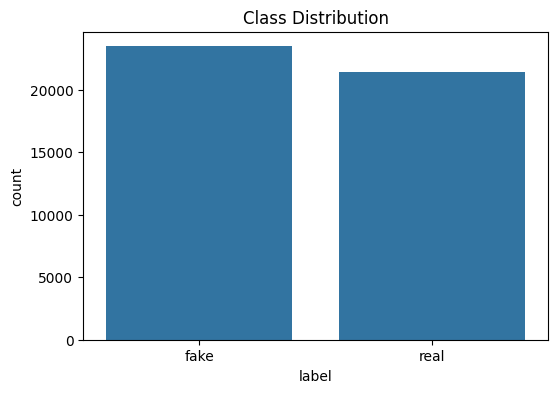

Percentage Distribution:
 label
fake    52.3
real    47.7
Name: proportion, dtype: float64 

=== Text Length Statistics ===
count    44898.000000
mean      2469.109693
std       2171.617091
min          1.000000
25%       1234.000000
50%       2186.000000
75%       3105.000000
max      51794.000000
Name: text_length, dtype: float64 



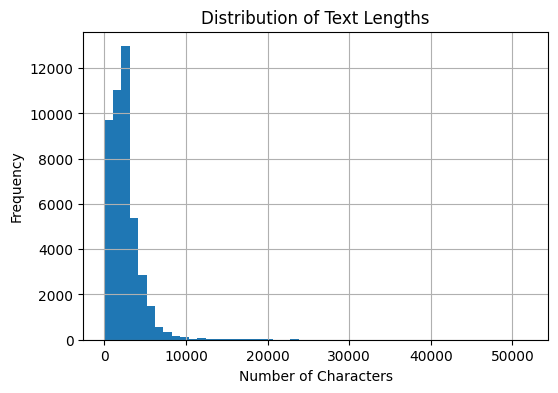

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) General statistical summary (numeric & categorical columns)
print("=== Numeric Summary ===")
print(df.describe(), "\n")
print("=== Categorical Summary ===")
print(df.describe(include='object'), "\n")

# 2) Missing value counts
print("=== Missing Values ===")
print(df.isnull().sum(), "\n")

# 3) Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

print("Percentage Distribution:\n", (df['label'].value_counts(normalize=True)*100).round(2), "\n")

# 4) Text length analysis
df['text_length'] = df['text'].apply(len)
print("=== Text Length Statistics ===")
print(df['text_length'].describe(), "\n")

plt.figure(figsize=(6,4))
df['text_length'].hist(bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

# 1) Özellik ve hedefi seç
X = df['clean_text'] if 'clean_text' in df else df['text']
y = df['label']

# 2) Eğitim/test ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3) Kontrol et
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 35918, Test samples: 8980


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Create a pipeline with TF-IDF vectorization and Logistic Regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.9,        # ignore terms that appear in more than 90% of documents
        min_df=5,          # ignore terms that appear in fewer than 5 documents
        ngram_range=(1,2)  # include unigrams and bigrams
    )),
    ('clf', LogisticRegression(
        solver='liblinear', random_state=42
    ))
])

# 2) Train the model on the training set
pipeline.fit(X_train, y_train)
print("Training completed.")

# 3) Make predictions on the test set and compute accuracy
y_pred = pipeline.predict(X_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))

# 4) Print a detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 5) Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Training completed.
Test Accuracy: 0.9886

Classification Report:
               precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4696
        real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
 [[4637   59]
 [  43 4241]]


In [16]:
from sklearn.model_selection import GridSearchCV

# 1) Define a parameter grid for TF-IDF and Logistic Regression
param_grid = {
    'tfidf__max_df':      [0.8, 0.9, 1.0],
    'tfidf__min_df':      [3, 5, 7],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C':             [0.01, 0.1, 1, 10]
}

# 2) Wrap your existing pipeline in GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# 3) Fit the grid search
grid_search.fit(X_train, y_train)

# 4) Print best params & CV score
print("Best params:", grid_search.best_params_)
print("Best CV f1-weighted:", round(grid_search.best_score_, 4))

# 5) Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nTest Accuracy (best model):", round(accuracy_score(y_test, y_pred_best), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: {'clf__C': 10, 'tfidf__max_df': 0.9, 'tfidf__min_df': 7, 'tfidf__ngram_range': (1, 2)}
Best CV f1-weighted: 0.9926

Test Accuracy (best model): 0.9949

Classification Report:
               precision    recall  f1-score   support

        fake       0.99      1.00      1.00      4696
        real       1.00      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
 [[4675   21]
 [  25 4259]]


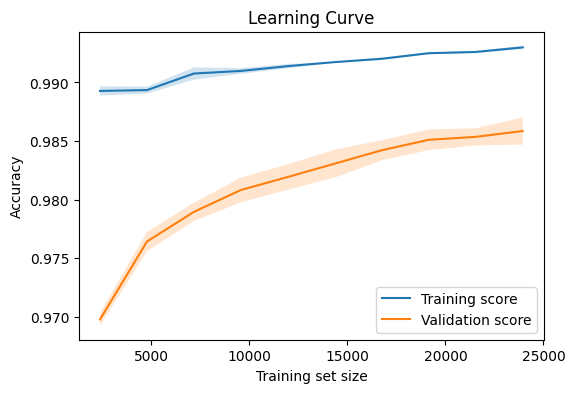

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# 1) Eğitim boyutlarını ve skorları alıyoruz
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# 2) Ortalama + std’yi hesapla
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# 3) Görselleştir
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean,  label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, val_mean,    label='Validation score')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.title('Learning Curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
import pandas as pd
import numpy as np

# 1) Test setini bir DataFrame’e al
df_test = pd.DataFrame({
    'text':   X_test,
    'true':   y_test,
    'pred':   pipeline.predict(X_test)
})

# 2) “doğru” ve “yanlış” alt kümeleri
correct = df_test[df_test['true']==df_test['pred']]
wrong   = df_test[df_test['true']!=df_test['pred']]

# 3) Rastgele seç 3’er örnek
sample_correct = correct.sample(3, random_state=42)
sample_wrong   = wrong.sample(3, random_state=42)

# 4) Birleştirip göster
display(pd.concat([sample_correct, sample_wrong]))


,text,true,pred
18481,MELBOURNE (Reuters) - Australian Prime Ministe...,real,real
13036,BUDAPEST (Reuters) - Hungary s right-wing Prim...,real,real
1227,"MIRANSHAH, Pakistan (Reuters) - A bomb rigged ...",real,real
36782,"A number of European politicians, including J...",fake,real
12287,In what amounts to an 11th hour gift by the ...,fake,real
33099,Wow! Republicans had a chance to stand up to t...,fake,real


In [20]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(pipeline, f)
print("Model Recorded: model.pkl")


Model Recorded: model.pkl
